In [4]:
import pandas as pd
# from func_utils.utils import save_tocsv

import plotly.express as px
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from dotenv import load_dotenv
import os
import mlflow



# Collect data

### Collect prod data (target)

In [5]:
data_prod_path = '../../data/prod/eCO2mix_RTE_Auvergne-Rhone-Alpes_cleaned.csv'

# read csv
df_prod = pd.read_csv(data_prod_path)
data_prod = df_prod.copy()

# formatting the date for future data merge operations
data_prod['Time'] = pd.to_datetime(data_prod['date']+" "+data_prod['heures'])


### Collect Landsat data

In [6]:
data_sat_path = '../../data/LandSat/result_EarthExplorer_region_ARA.csv'

# read csv
df_sat = pd.read_csv(data_sat_path, encoding='ISO-8859-1', sep=';')
data_sat = df_sat.copy()

# formatting the date column "Start Time" for future data merge operations
time1 = pd.to_datetime(data_sat['Start Time'].str[:16], format='%d/%m/%Y %H:%M', errors='coerce')
time2 = pd.to_datetime(data_sat['Start Time'].str[:16], format='%Y-%m-%d %H:%M', errors='coerce')

data_sat['Time'] = time1
data_sat['Time'] = data_sat['Time'].fillna(time2)
data_sat['Time']=data_sat['Time'].dt.round('30min') #to match the production data

### Merge data (inner merge)

In [4]:
# group the landsat data by the time variable to aggregate the images data
sat_columns_to_use = ['Land Cloud Cover', 'Scene Cloud Cover L1','Sun Elevation L0RA', 'Sun Azimuth L0RA']
data_sat_grouped = data_sat.groupby('Time')[sat_columns_to_use].mean().reset_index()

# select columns from production data
prod_columns_to_use = ['Time', 'solaire', 'tco_solaire_(%)', 'tch_solaire_(%)']
data_prod_limited = data_prod[prod_columns_to_use]

merged_data = data_sat_grouped.merge(data_prod_limited, on='Time', how='inner')
# save_tocsv(merged_data, '../../data/compiled_data/sat_only_data.csv')


# Visualisation

In [50]:
px.scatter(merged_data, x='Time', y=['Land Cloud Cover', 'Sun Elevation L0RA', 'Sun Azimuth L0RA', 'tch_solaire_(%)'])

In [51]:
px.scatter(merged_data, x='Land Cloud Cover', y='tch_solaire_(%)', trendline='ols')

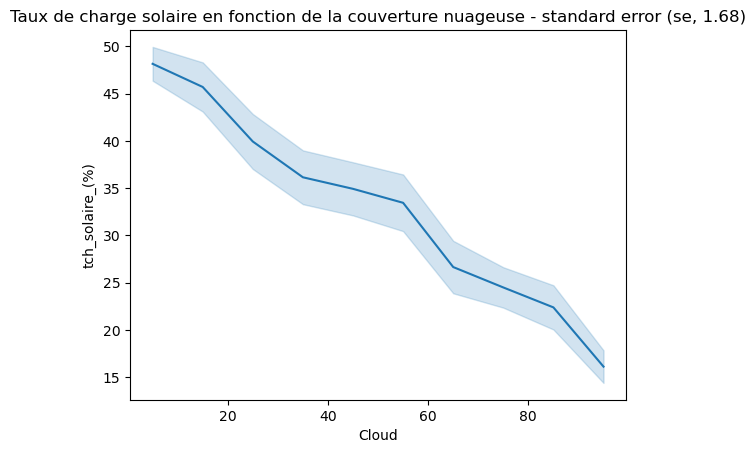

In [52]:
merged_data['Cloud'] = pd.cut(merged_data['Land Cloud Cover'], bins=10, labels=range(5,100,10))
sns.lineplot(merged_data, x='Cloud', y='tch_solaire_(%)', errorbar=('se',1.68))
plt.title("Taux de charge solaire en fonction de la couverture nuageuse - standard error (se, 1.68)")
plt.show()

# Modeles

In [5]:
y = merged_data['tch_solaire_(%)'].to_numpy() #target
x = merged_data[['Land Cloud Cover','Sun Elevation L0RA']] #features

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=42)

# Preprocessing
sc = StandardScaler()
sc.fit(x_train)

x_train = sc.transform(x_train)
x_test = sc.transform(x_test)


In [7]:
x_train

array([[-0.87639817, -1.12806006],
       [ 0.79605793, -1.37682675],
       [ 1.54905515, -0.69073236],
       ...,
       [-1.17806539,  0.68378174],
       [-0.47246139,  1.22743088],
       [ 1.4264233 , -1.12047059]], shape=(570, 2))

In [8]:
sc.get_feature_names_out()
pd.DataFrame(x_train, columns=sc.get_feature_names_out())

,Land Cloud Cover,Sun Elevation L0RA
0,-0.876398,-1.128060
1,0.796058,-1.376827
2,1.549055,-0.690732
3,1.134886,0.827842
4,-0.737578,1.311112
...,...,...
565,0.834441,0.722407
566,-0.136942,-1.214904
567,-1.178065,0.683782
568,-0.472461,1.227431


In [ ]:

# pour enregistrer dans MLFlow
load_dotenv()

os.environ["APP_URI"] = "https://renergies99-mlflow.hf.space/"
EXPERIMENT_NAME="first_landsat_models"

mlflow.set_tracking_uri(os.environ["APP_URI"])
mlflow.set_experiment(EXPERIMENT_NAME)
experiment = mlflow.get_experiment_by_name(EXPERIMENT_NAME)

mlflow.sklearn.autolog()

# model 1
run_description = """
colonnes utilisées : ['Land Cloud Cover','Sun Elevation L0RA']
\n target = 'tch_solaire_(%)'
"""

with mlflow.start_run(experiment_id = experiment.experiment_id, description=run_description):
    model = LinearRegression()
    model.fit(x_train, y_train)

    score = model.score(x_test, y_test)
    
    mlflow.log_metric("ScoreR2", score)
    mlflow.sklearn.log_model(model, "model")

print('model_score_train: ', model.score(x_train,y_train))
print('model_score_test: ', model.score(x_test,y_test))


2025/11/14 15:50:49 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


🏃 View run secretive-yak-691 at: https://renergies99-mlflow.hf.space/#/experiments/2/runs/1b9cbe0ddef54998b48d425fa7d07482
🧪 View experiment at: https://renergies99-mlflow.hf.space/#/experiments/2
model_score_train:  0.7149454308650398
model_score_test:  0.6740873383272943
